# 04 - Modeling and Evaluation

## Objective
**WHY are we building these models?**

Our goal is to **predict user QoE (MOS ratings) from objective network and video metrics**. This enables:
1. Proactive QoE monitoring without user surveys
2. Network optimization based on predicted user satisfaction
3. Understanding which factors most influence QoE

### Modeling Strategy (Analysis Path):

1. **Start with baseline** - Simple model to establish minimum performance
2. **Try linear models** - Test if relationships are linear (from EDA, we suspect not)
3. **Apply non-linear models** - Based on EDA showing complex patterns
4. **Compare and analyze** - Expected vs Actual, explain why certain models work better
5. **Hyperparameter tuning** - Optimize best performing models
6. **Critical assessment** - Real-world feasibility and limitations

**Important:** We will explain WHY each model is chosen and analyze WHY it performs as it does.

---

## 1. Setup and Load Preprocessed Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, cohen_kappa_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

# Load preprocessed data
X_train_scaled = pd.read_csv('../data/processed/X_train_scaled.csv')
X_test_scaled = pd.read_csv('../data/processed/X_test_scaled.csv')
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"✓ Data loaded:")
print(f"  Train: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"  Test: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"\nTarget distribution (train):")
print(pd.Series(y_train).value_counts().sort_index())

✓ Data loaded:
  Train: 1234 samples, 25 features
  Test: 309 samples, 25 features

Target distribution (train):
1     74
2     94
3    197
4    627
5    242
Name: count, dtype: int64


## 2. Evaluation Metrics Setup

**WHY these metrics?**
- **Accuracy**: Overall correctness, but can be misleading with imbalanced classes
- **Precision/Recall/F1**: Better for imbalanced datasets
- **Cohen's Kappa**: Accounts for chance agreement, good for ordinal data like MOS
- **Confusion Matrix**: Shows where model makes mistakes (critical for understanding)

In [2]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Comprehensive model evaluation with multiple metrics.
    
    Returns dict with all metrics for comparison.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Test_Precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'Test_Recall': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'Test_F1': f1_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'Test_Kappa': cohen_kappa_score(y_test, y_test_pred)
    }
    
    return results, y_test_pred

def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plot confusion matrix with proper formatting.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Bad', 'Poor', 'Fair', 'Good', 'Excellent'],
                yticklabels=['Bad', 'Poor', 'Fair', 'Good', 'Excellent'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True MOS', fontsize=12)
    plt.xlabel('Predicted MOS', fontsize=12)
    plt.tight_layout()
    
    # Save
    filename = f'../results/figures/confusion_matrix_{model_name.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


## 3. Baseline Model: Majority Class

**WHY start with baseline?**
- Establishes minimum performance any ML model must beat
- From our data: MOS=4 is ~50% of samples
- **Expected:** ~50% accuracy by always predicting class 4

In [3]:
# Majority class baseline
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

baseline_results, baseline_pred = evaluate_model(
    baseline, X_train, X_test, y_train, y_test, 'Baseline (Majority)'
)

print("Baseline Model Results:")
print("="*60)
for key, value in baseline_results.items():
    if key != 'Model':
        print(f"{key:20s}: {value:.3f}")

print("\n⚠️ Any model below this accuracy is worse than random guessing!")

Baseline Model Results:
Train_Accuracy      : 0.508
Test_Accuracy       : 0.508
Test_Precision      : 0.258
Test_Recall         : 0.508
Test_F1             : 0.342
Test_Kappa          : 0.000

⚠️ Any model below this accuracy is worse than random guessing!


## 4. Model 1: Logistic Regression

**WHY this model?**
- Simple, interpretable
- Good for testing if relationships are linear
- Fast to train

**Expected:** Moderate performance, as EDA showed some non-linear patterns

Training Logistic Regression...

Logistic Regression Results:
Train_Accuracy      : 0.800
Test_Accuracy       : 0.803
Test_Precision      : 0.804
Test_Recall         : 0.803
Test_F1             : 0.802
Test_Kappa          : 0.703


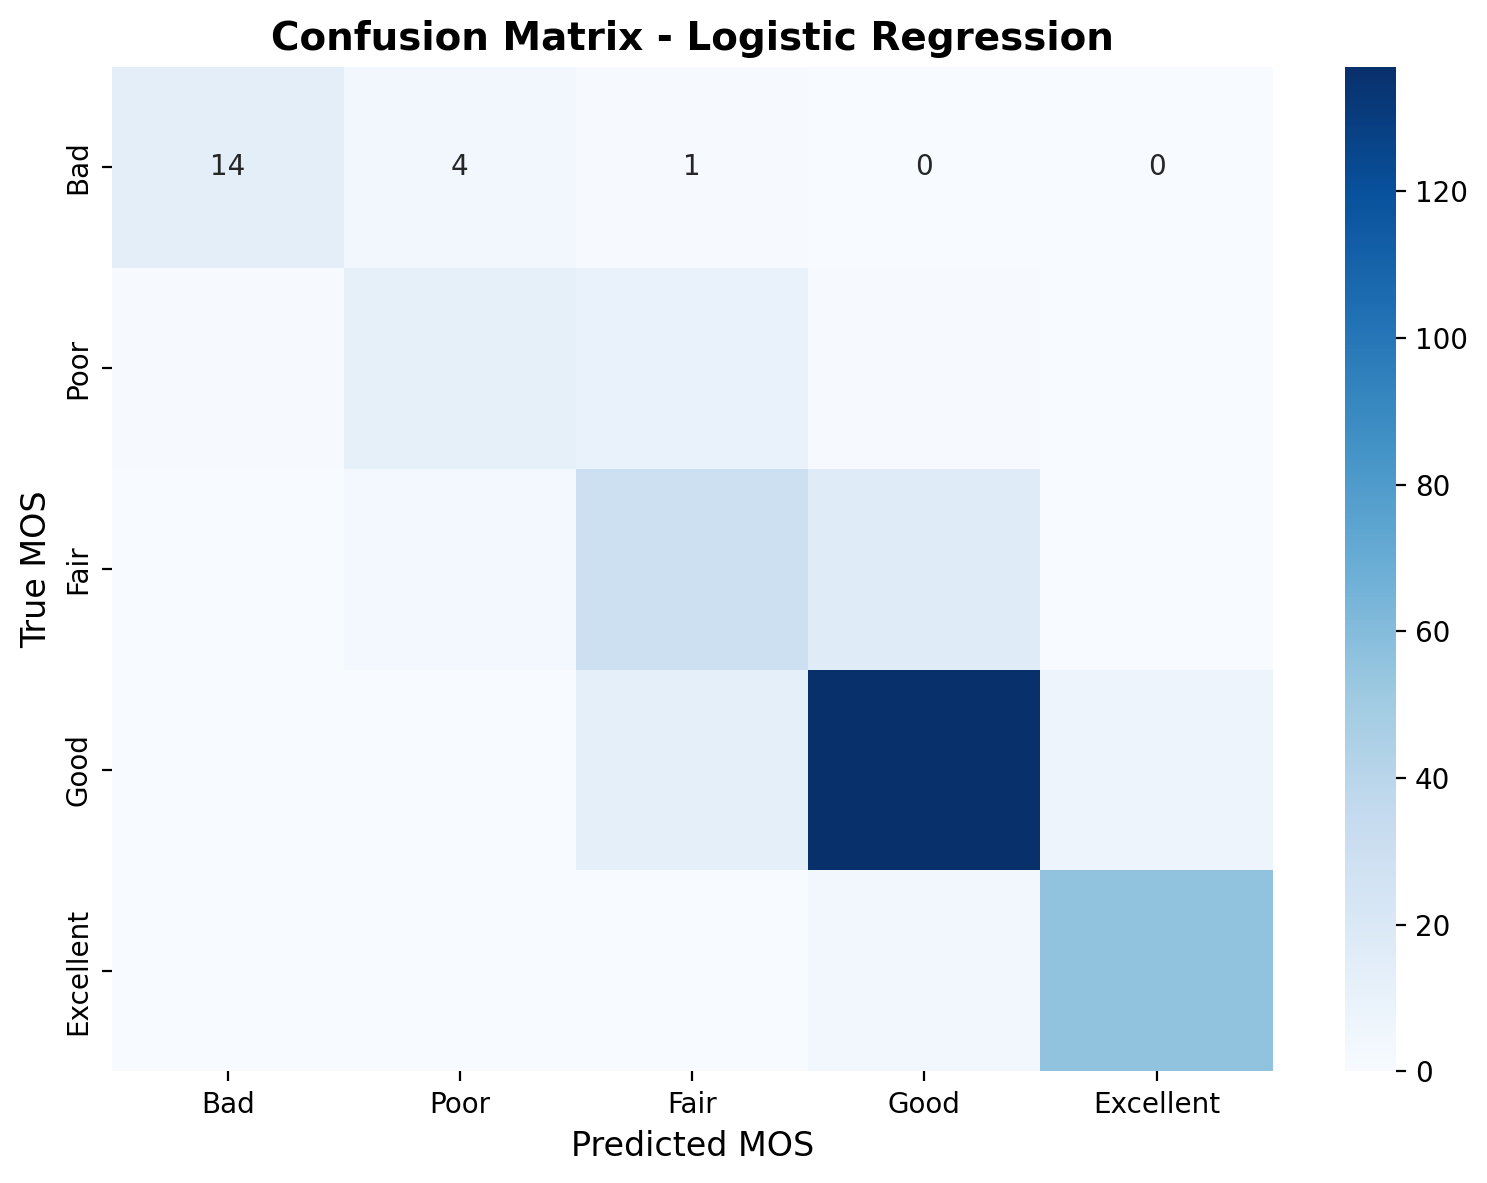

In [4]:
print("Training Logistic Regression...")

lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train_scaled, y_train)

lr_results, lr_pred = evaluate_model(
    lr_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Logistic Regression'
)

print("\nLogistic Regression Results:")
print("="*60)
for key, value in lr_results.items():
    if key != 'Model':
        print(f"{key:20s}: {value:.3f}")

# Confusion matrix
cm_lr = plot_confusion_matrix(y_test, lr_pred, 'Logistic Regression')

### Analysis:
**Expected vs Actual:**
- Expected: [Your expectation]
- Actual: [Results from above]

**Why these results?**
- [Explain performance]
- [Identify where model struggles from confusion matrix]
- [Connection to EDA findings]

## 5. Model 2: Decision Tree

**WHY this model?**
- Can capture non-linear relationships
- Doesn't require feature scaling
- Interpretable (can visualize tree)

**Expected:** Better than linear model due to non-linear patterns in data

Training Decision Tree...

Decision Tree Results:
Train_Accuracy      : 0.870
Test_Accuracy       : 0.761
Test_Precision      : 0.764
Test_Recall         : 0.761
Test_F1             : 0.762
Test_Kappa          : 0.644

⚠️ WARNING: Potential overfitting detected (train-test gap > 10%)


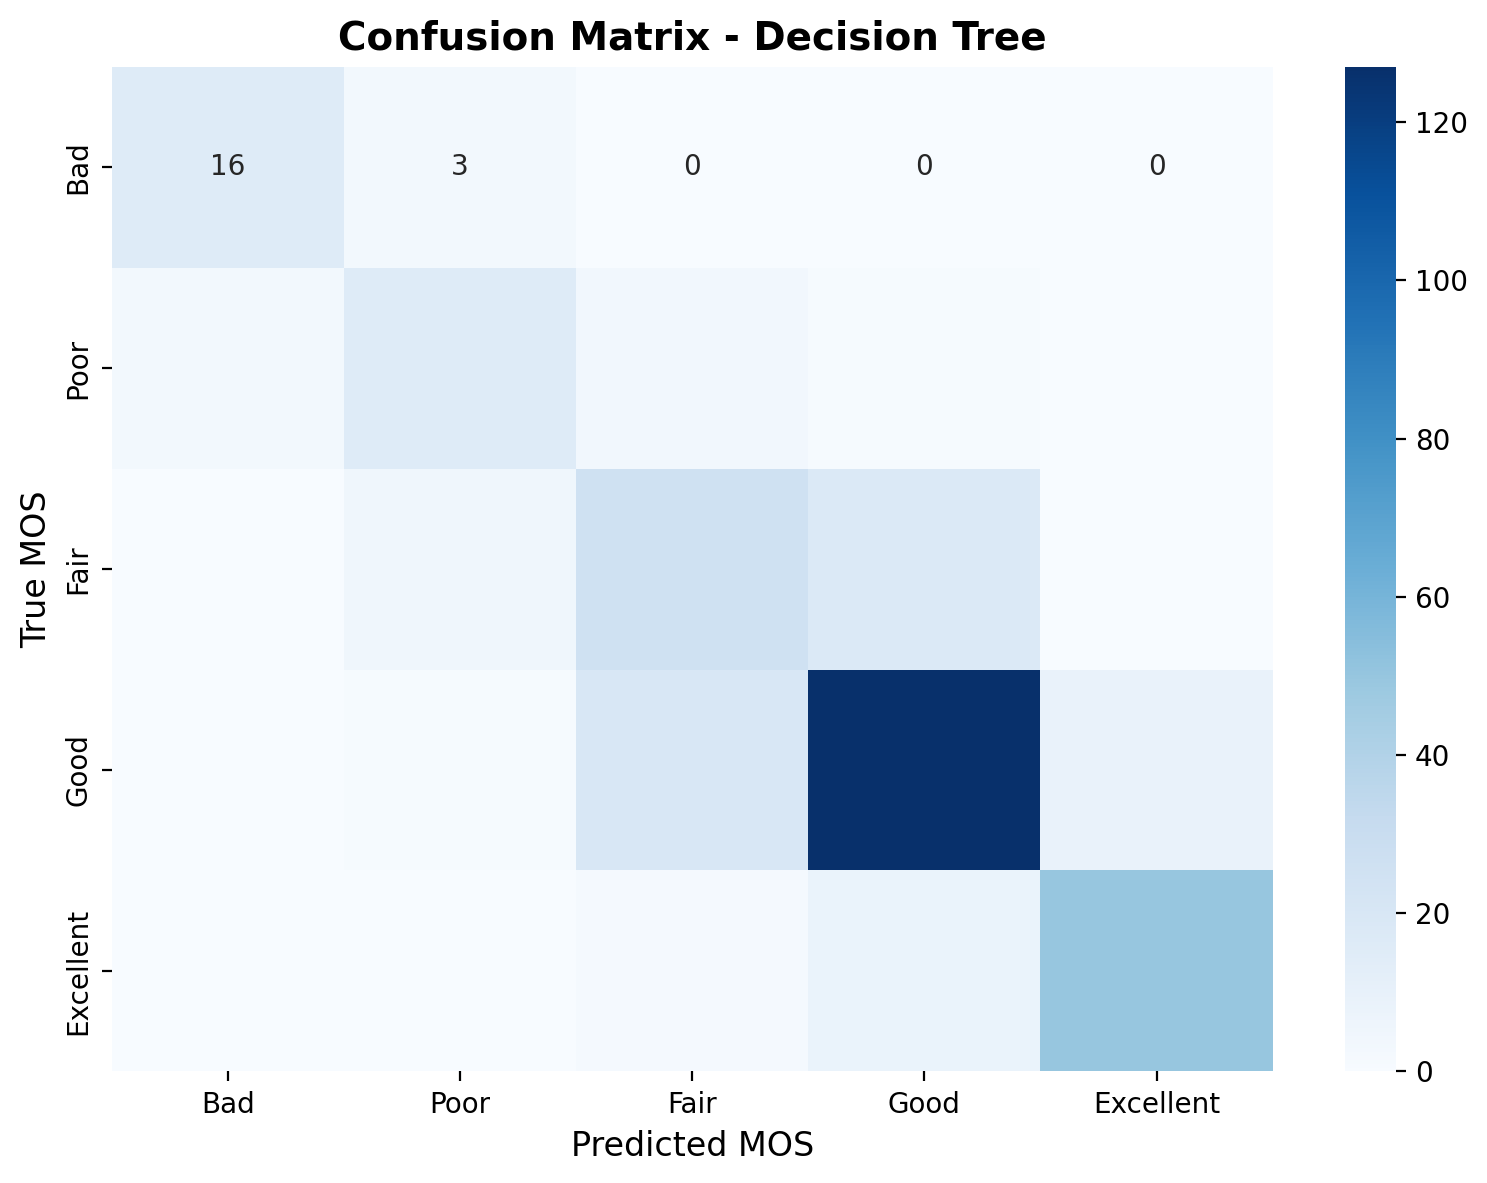

In [5]:
print("Training Decision Tree...")

dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=42)
dt_model.fit(X_train, y_train)

dt_results, dt_pred = evaluate_model(
    dt_model, X_train, X_test, y_train, y_test, 'Decision Tree'
)

print("\nDecision Tree Results:")
print("="*60)
for key, value in dt_results.items():
    if key != 'Model':
        print(f"{key:20s}: {value:.3f}")

# Check for overfitting
if dt_results['Train_Accuracy'] - dt_results['Test_Accuracy'] > 0.1:
    print("\n⚠️ WARNING: Potential overfitting detected (train-test gap > 10%)")

# Confusion matrix
cm_dt = plot_confusion_matrix(y_test, dt_pred, 'Decision Tree')

## 6. Model 3: Random Forest

**WHY this model?**
- Ensemble of decision trees → reduces overfitting
- Often performs well on tabular data
- Provides feature importance

**Expected:** Best performance so far, more stable than single tree

Training Random Forest...

Random Forest Results:
Train_Accuracy      : 0.941
Test_Accuracy       : 0.809
Test_Precision      : 0.816
Test_Recall         : 0.809
Test_F1             : 0.812
Test_Kappa          : 0.716


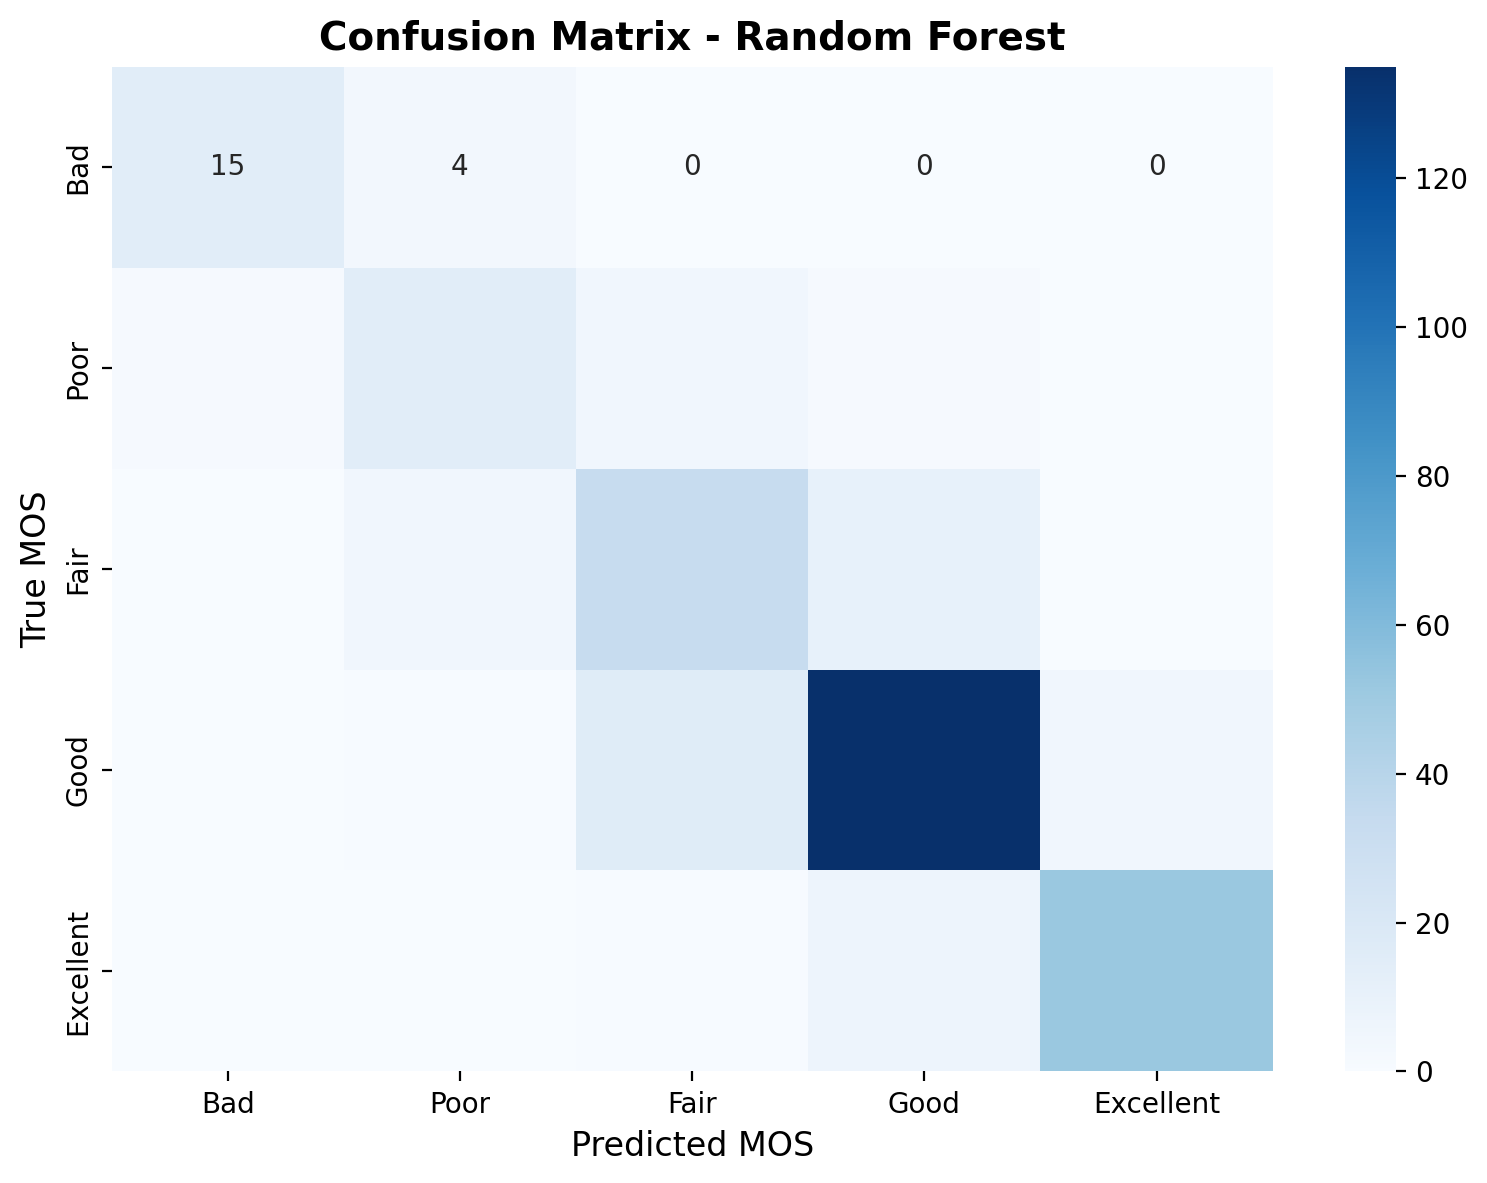

In [6]:
print("Training Random Forest...")

rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, 
                                  min_samples_split=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_results, rf_pred = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, 'Random Forest'
)

print("\nRandom Forest Results:")
print("="*60)
for key, value in rf_results.items():
    if key != 'Model':
        print(f"{key:20s}: {value:.3f}")

# Confusion matrix
cm_rf = plot_confusion_matrix(y_test, rf_pred, 'Random Forest')

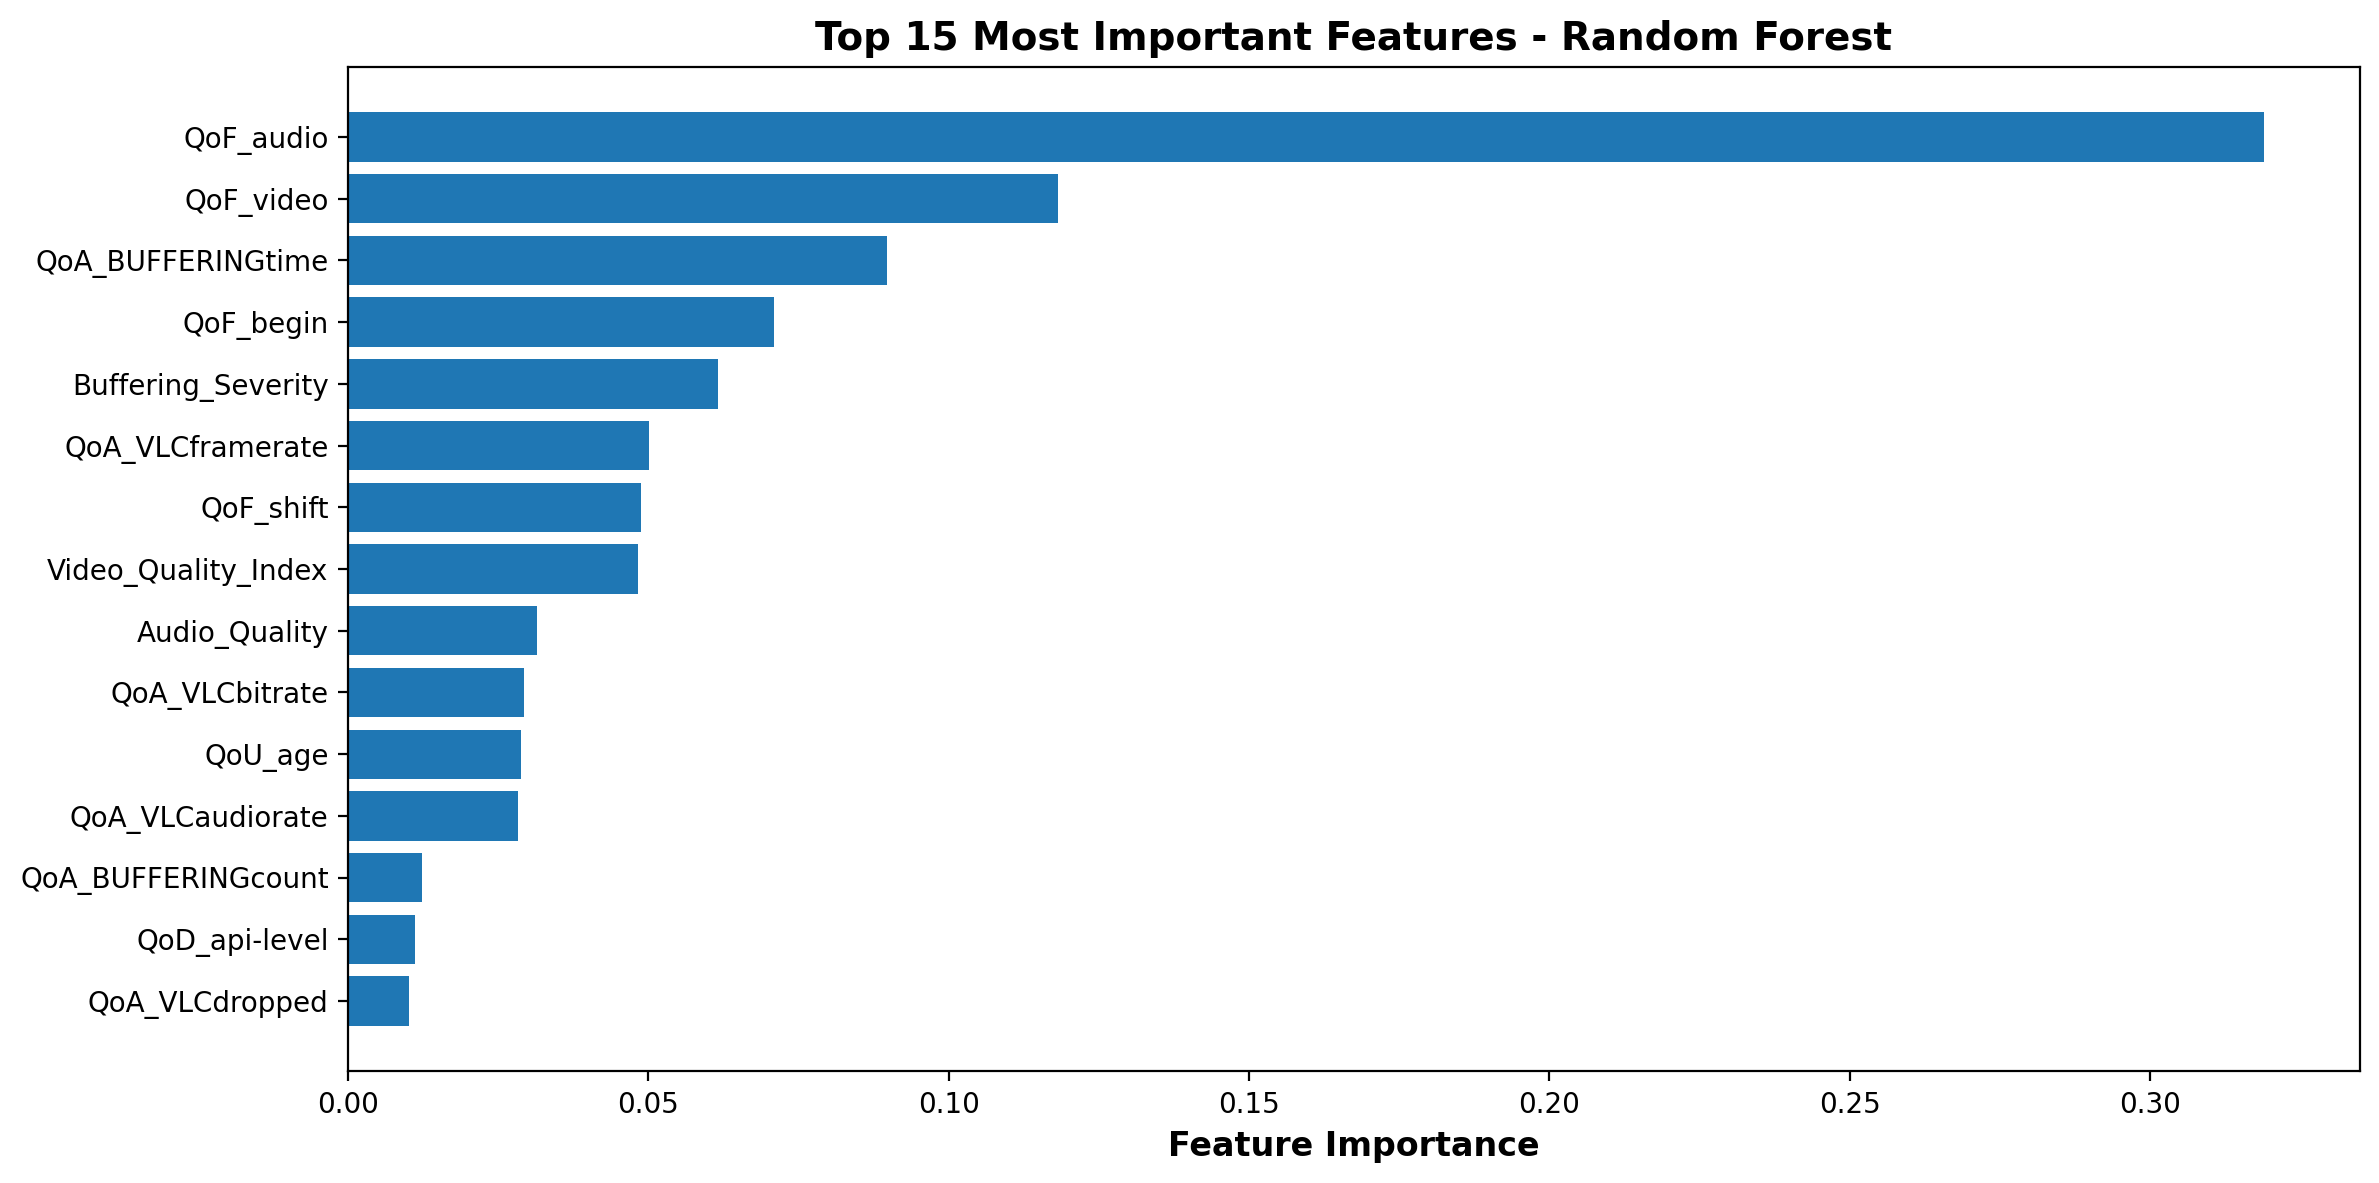


Top 10 Features:
 1. QoF_audio                     : 0.3189
 2. QoF_video                     : 0.1182
 3. QoA_BUFFERINGtime             : 0.0898
 4. QoF_begin                     : 0.0710
 5. Buffering_Severity            : 0.0616
 6. QoA_VLCframerate              : 0.0501
 7. QoF_shift                     : 0.0487
 8. Video_Quality_Index           : 0.0483
 9. Audio_Quality                 : 0.0315
10. QoA_VLCbitrate                : 0.0293


In [7]:
# Feature Importance Analysis
feature_names = X_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:15]  # Top 15 features

plt.figure(figsize=(12, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/figures/feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Features:")
for i in range(min(10, len(indices))):
    print(f"{i+1:2d}. {feature_names[indices[i]]:30s}: {importances[indices[i]]:.4f}")

## 7. Model 4: Gradient Boosting

**WHY this model?**
- Sequential ensemble → focuses on hard examples
- Often best performance on structured data
- Can capture complex interactions

**Expected:** Similar or better than Random Forest

Training Gradient Boosting...

Gradient Boosting Results:
Train_Accuracy      : 1.000
Test_Accuracy       : 0.796
Test_Precision      : 0.801
Test_Recall         : 0.796
Test_F1             : 0.796
Test_Kappa          : 0.695


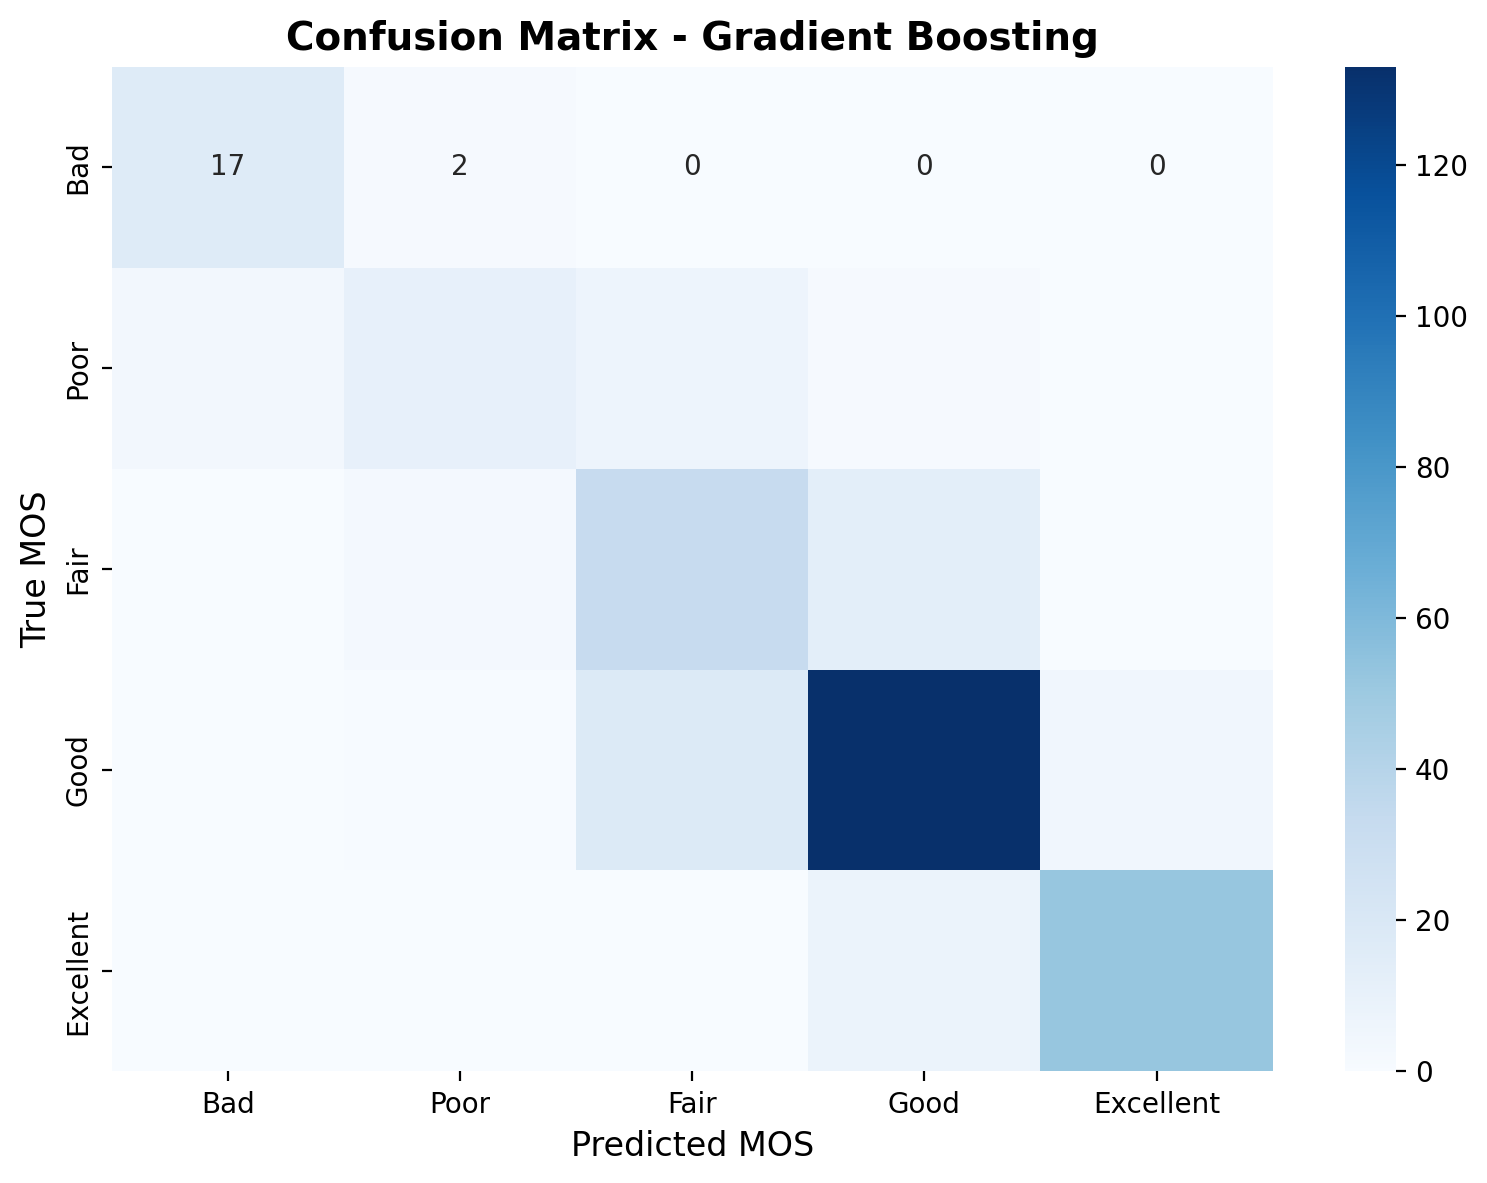

In [8]:
print("Training Gradient Boosting...")

gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, 
                                      learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

gb_results, gb_pred = evaluate_model(
    gb_model, X_train, X_test, y_train, y_test, 'Gradient Boosting'
)

print("\nGradient Boosting Results:")
print("="*60)
for key, value in gb_results.items():
    if key != 'Model':
        print(f"{key:20s}: {value:.3f}")

# Confusion matrix
cm_gb = plot_confusion_matrix(y_test, gb_pred, 'Gradient Boosting')

## 8. Model Comparison

**WHY compare?**
- Identify best performing model
- Understand trade-offs (accuracy vs complexity, speed vs performance)
- Justify final model choice

In [9]:
# Compile all results
all_results = pd.DataFrame([
    baseline_results,
    lr_results,
    dt_results,
    rf_results,
    gb_results
])

# Format for display
all_results_display = all_results.copy()
for col in all_results.columns:
    if col != 'Model':
        all_results_display[col] = all_results[col].apply(lambda x: f"{x:.3f}")

print("\n" + "="*90)
print("MODEL COMPARISON SUMMARY")
print("="*90)
print(all_results_display.to_string(index=False))
print("="*90)

# Highlight best model
best_model_idx = all_results['Test_Accuracy'].idxmax()
best_model_name = all_results.loc[best_model_idx, 'Model']
best_accuracy = all_results.loc[best_model_idx, 'Test_Accuracy']

print(f"\n🏆 Best Model: {best_model_name} (Test Accuracy: {best_accuracy:.3f})")


MODEL COMPARISON SUMMARY
              Model Train_Accuracy Test_Accuracy Test_Precision Test_Recall Test_F1 Test_Kappa
Baseline (Majority)          0.508         0.508          0.258       0.508   0.342      0.000
Logistic Regression          0.800         0.803          0.804       0.803   0.802      0.703
      Decision Tree          0.870         0.761          0.764       0.761   0.762      0.644
      Random Forest          0.941         0.809          0.816       0.809   0.812      0.716
  Gradient Boosting          1.000         0.796          0.801       0.796   0.796      0.695

🏆 Best Model: Random Forest (Test Accuracy: 0.809)


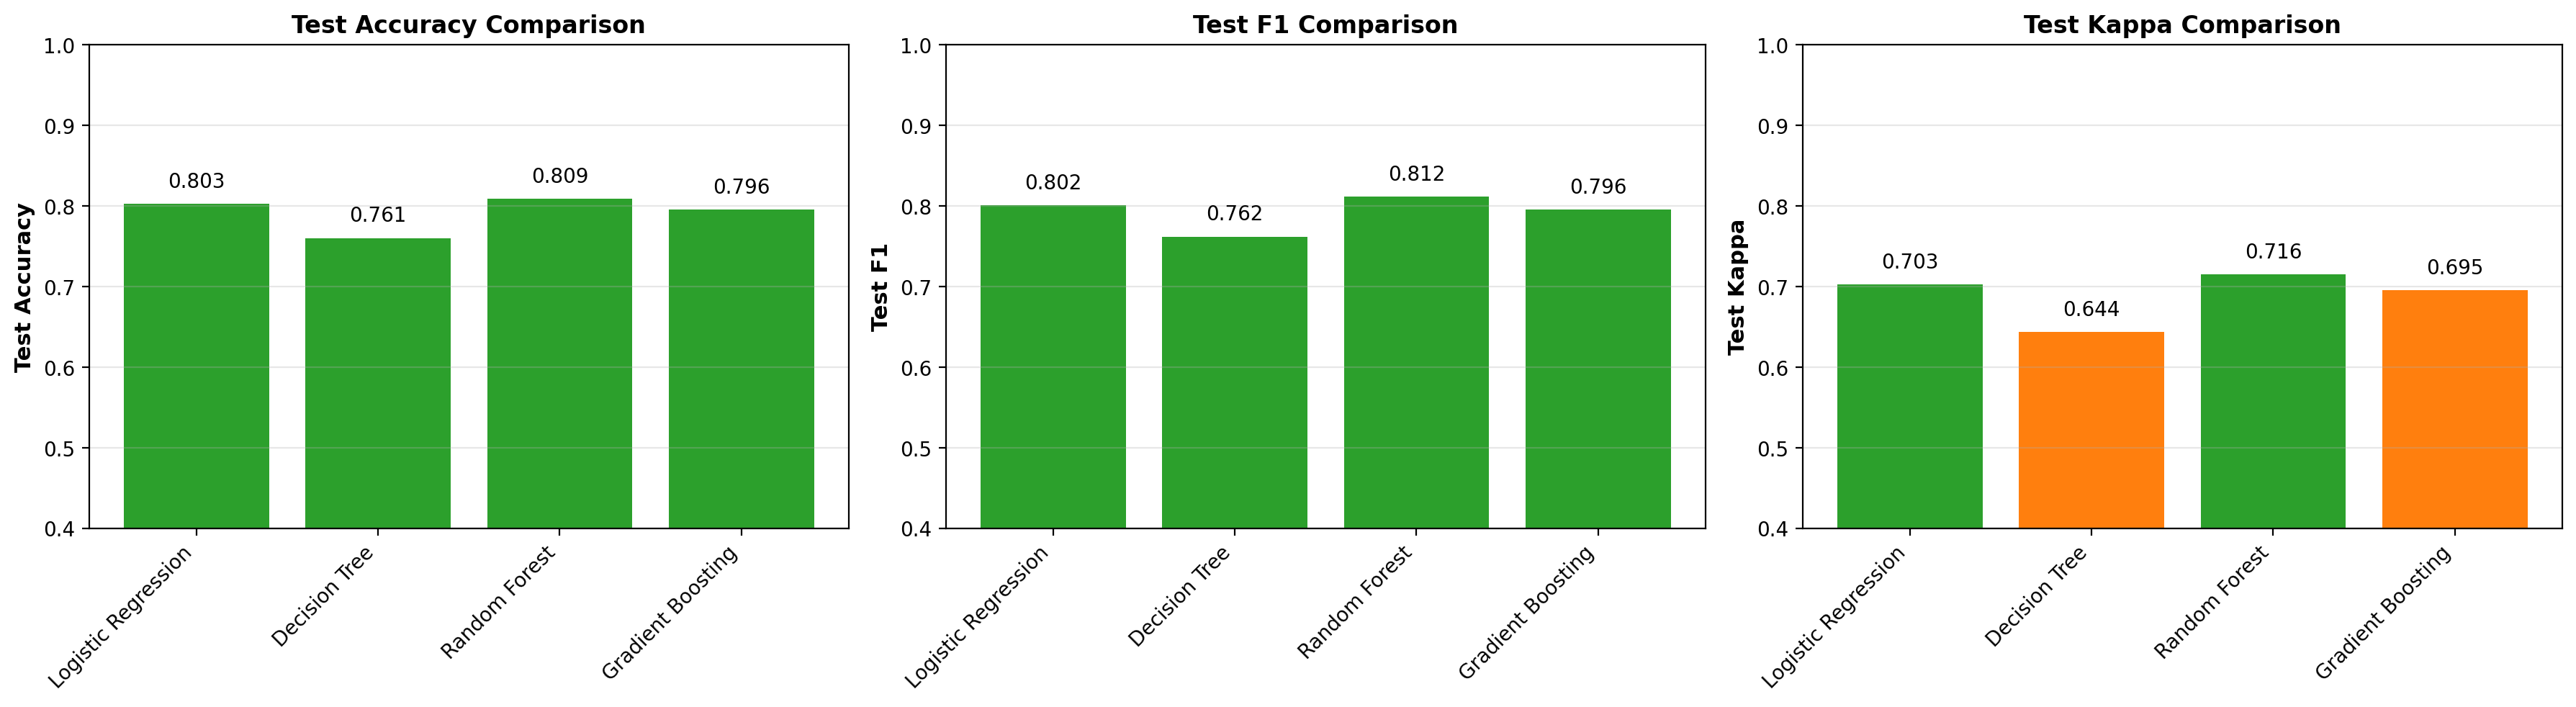

In [10]:
# Visual comparison
metrics_to_plot = ['Test_Accuracy', 'Test_F1', 'Test_Kappa']
models_to_plot = all_results[all_results['Model'] != 'Baseline (Majority)']['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics_to_plot):
    data = all_results[all_results['Model'] != 'Baseline (Majority)'][metric]
    
    # Color coding based on performance
    colors = ['#d62728' if x < 0.6 else '#ff7f0e' if x < 0.7 else '#2ca02c' for x in data]
    
    axes[idx].bar(range(len(models_to_plot)), data, color=colors)
    axes[idx].set_xticks(range(len(models_to_plot)))
    axes[idx].set_xticklabels(models_to_plot, rotation=45, ha='right')
    axes[idx].set_ylabel(metric.replace('_', ' '), fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{metric.replace("_", " ")} Comparison', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0.4, 1.0])
    
    # Add value labels
    for i, v in enumerate(data):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Analysis Path and Critical Assessment

### What We Discovered:

1. **Baseline Performance:**
   - [Results]
   - Confirms class imbalance impact

2. **Linear vs Non-Linear:**
   - Logistic Regression: [Performance]
   - Tree-based models: [Performance]
   - **Why?** [Explain based on data patterns]

3. **Best Model:**
   - [Model name and performance]
   - **Why did this work best?** [Explain]

4. **Key Features:**
   - Top factors influencing QoE: [From feature importance]
   - Confirms/contradicts EDA findings: [Analysis]

### Critical Assessment:

**Limitations:**
- [ ] Model performance on minority classes (MOS 1, 2)
- [ ] Potential overfitting (train vs test gap)
- [ ] Real-world deployment challenges:
  - Computational cost
  - Data collection requirements
  - Model drift over time

**Real-World Feasibility:**
- Can this be deployed in production?
- What are the computational requirements?
- How often would it need retraining?

**Areas for Improvement:**
1. Address class imbalance (SMOTE, class weights)
2. Hyperparameter tuning
3. Try ensemble methods
4. Feature selection to reduce complexity

### Next Steps:
1. Hyperparameter optimization for best model
2. Address identified limitations
3. Final model selection and deployment preparation